In [2]:
"""

This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional 
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import scipy
import operator
from functools import reduce
from functools import partial
from timeit import default_timer


import matplotlib.pyplot as plt

################################################################
#  1d fourier layer
################################################################

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1,dtype=torch.cfloat))           #use the scaling factor to initialise complex weights of dimensions [in_channels, out_channels, modes]

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        #do a complex multiplication of the form written above with truncated fourier modes and weights to do linear transformation 'R'
        #HINT : use 'torch.einsum'
        
        return torch.einsum("bix,iox->box", input, weights)        

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #HINT : you can use a torch function to do a fft of a real valued input 'x' so that output contains only positive frequencies
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:,:,:self.modes1], self.weights1)
        #call compl_mul1d function to enable linear transformation of selected modes and complex weights initiated above
        #print(out_ft)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=x.size(-1))  #do an inverse fft of out_ft to shift from fourier space to real space using torch function
        return x

    

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, 64) # input channel is 2: (a(x), x); uplift from 2 features to 64 features using torch linear neural network

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)                          #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.w0 = nn.Conv1d(self.width, self.width,1)                               #bias term parallel to fourier layer of size (w), that do a 1D convolution
        self.w1 = nn.Conv1d(self.width, self.width,1)
        self.w2 = nn.Conv1d(self.width, self.width,1)
        self.w3 = nn.Conv1d(self.width, self.width,1)

        self.fc1 = nn.Linear(self.width, 128)                             #project from channel width to a 128 layer neural network (width, 128)
        self.fc2 = nn.Linear(128,1)                              #project from a 128 layer neural network to a single output neuron (128,1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)   #input now contains (a(x), x)
        x = self.fc0(x)                               #call fc0 layer initiated above to shift from 2 to 64 
        x = x.permute(0, 2, 1)   #permute layers to change order to allow for fft and linear transformation of x from (0,1,2)----> (0,2,1)
        

        x1 = self.conv0(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w0(x1)                         #pass x through first bias convolution layer w0
        x =  x1+x2                        # add x1 and x2
        x =  torch.nn.functional.gelu(x)                        #pass through activation 'gelu'

        x1 = self.conv1(x)                        #consecutively pass through spectral convolution and bias convolution layer
        x2 = self.w1(x1)
        x = x1+x2
        x = torch.nn.functional.gelu(x)

        x1 = self.conv2(x)                        #consecutively pass through spectral convolution and bias convolution layer
        x2 = self.w2(x1)
        x = x1+x2
        x = torch.nn.functional.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2


        x = x.permute(0, 2, 1)     #permute back to original shape 
        x = self.fc1(x)                       #uplift from channel width to 128 layer network
        x = torch.nn.functional.gelu(x)                       #pass through activation gelu
        x = self.fc2(x)                      #shift to real space
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

class LpLoss(object):
    def __init__(self, p=2):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert p > 0
        self.p = p



    def rel(self, x, y):
        num_examples = x.size()[0]

        while len(y.shape) > len(x.shape):
            y = y.squeeze(dim = len(y.shape))
        diff_norms = torch.norm((x-y), 2) #calculate norm between ground truth and predicted truth making sure their dimensions are compatible
        y_norms = torch.norm((x),2)#calculate norm of ground truth


        return torch.sum(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)
    
################################################################
#  configurations
################################################################
ntrain = int(0.75*2084)
ntest = 2084-ntrain

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = scipy.io.loadmat('burgers_data_R10.mat')
x_data = dataloader['a'][:,::sub]
y_data = dataloader['u'][:,::sub]
x_data= x_data.astype(np.float32)
x_data= torch.from_numpy(x_data)
y_data= y_data.astype(np.float32)
y_data= torch.from_numpy(y_data)
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c
# model
model = FNO1d(modes, width)
print(count_params(model))
total_steps = int(1000*500/20)

################################################################
# training and evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)       #use Adam optimizer from torch with appropriate arguments 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=total_steps, epochs = epochs,cycle_momentum=True, \
                                                max_momentum=0.95, div_factor =25, final_div_factor=1e4)       # use a learning rate scheduler
train_mseList=[]
train_l2List=[]
myloss = LpLoss() #initialise Lploss class object to calculate 'L2-norm'
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)
        out = out.squeeze(dim=2)
        mse = torch.mean((y - out)**2) #calculate mse loss between forward pass of network and y data by reshaping out and y to be of compatible shapes
         #calculate L2-loss by calling the 'rel' function defined Lploss class
        l2 = myloss.rel(y,out)
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        train_mseList.append(train_mse)
        train_l2List.append(train_l2)

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:

            out = model(x)
            out = out.squeeze(dim=2)
            t_l2 = myloss.rel(y,out)
            test_l2 += t_l2.item() #calculate test L2 loss

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    if ep%25==0:

        print(ep, train_mse, train_l2, test_l2)

torch.save(model, 'ns_fourier_burgers1')
pred = model.forward(x_train)
pred = pred.squeeze(dim=-1)
test_pred = model.forward(x_test)
test_pred = test_pred.squeeze(dim=-1)

print("___________Training Loss______________")
print(train_l2)
print("___________Testing Loss________________")
print(test_l2)

549569
0 0.05119608203243889 0.017192584887309022 0.004888616259175848
25 0.0001862467672967623 0.0013674632976843392 0.0011931014266901878
50 0.00010958791889480162 0.0010409471569958208 0.0005702794620663557
75 7.890482604263433e-05 0.0008971548680351929 0.00106729572949906
100 0.00018379624132741144 0.0012870800871490212 0.0018431623886391206
125 7.922734363966834e-05 0.0008846150701645087 0.0009515999553585693
150 9.771030643237225e-05 0.0009836133006991138 0.0008432565761047224
175 0.0001719767189362894 0.0012409507058041263 0.0010049957889284144
200 4.332784398304537e-05 0.0006566643220344493 0.0008051860845163321
225 2.8564919790093157e-05 0.0005450065778622015 0.00044445228993520857
250 4.110923401651833e-05 0.0006402907353812163 0.0007372127735054195
275 3.212039751539308e-05 0.0005749340558821432 0.000391187030114162
300 5.470614000899596e-05 0.0007462620884728257 0.0005672952095886796
325 4.382205288148046e-05 0.0006521489680938361 0.0010358752707831005
350 1.998746526474354

**Plotting**

I have plotted the 'i-th' row in x-axis and 'i+1-th' row in y-axis for ground truth (in RED) and model prediction(in BLACK) for TRAINING Dataset:
I have done this to show the match between predictions and ground truth for different rows. Predictions are pretty accurate.

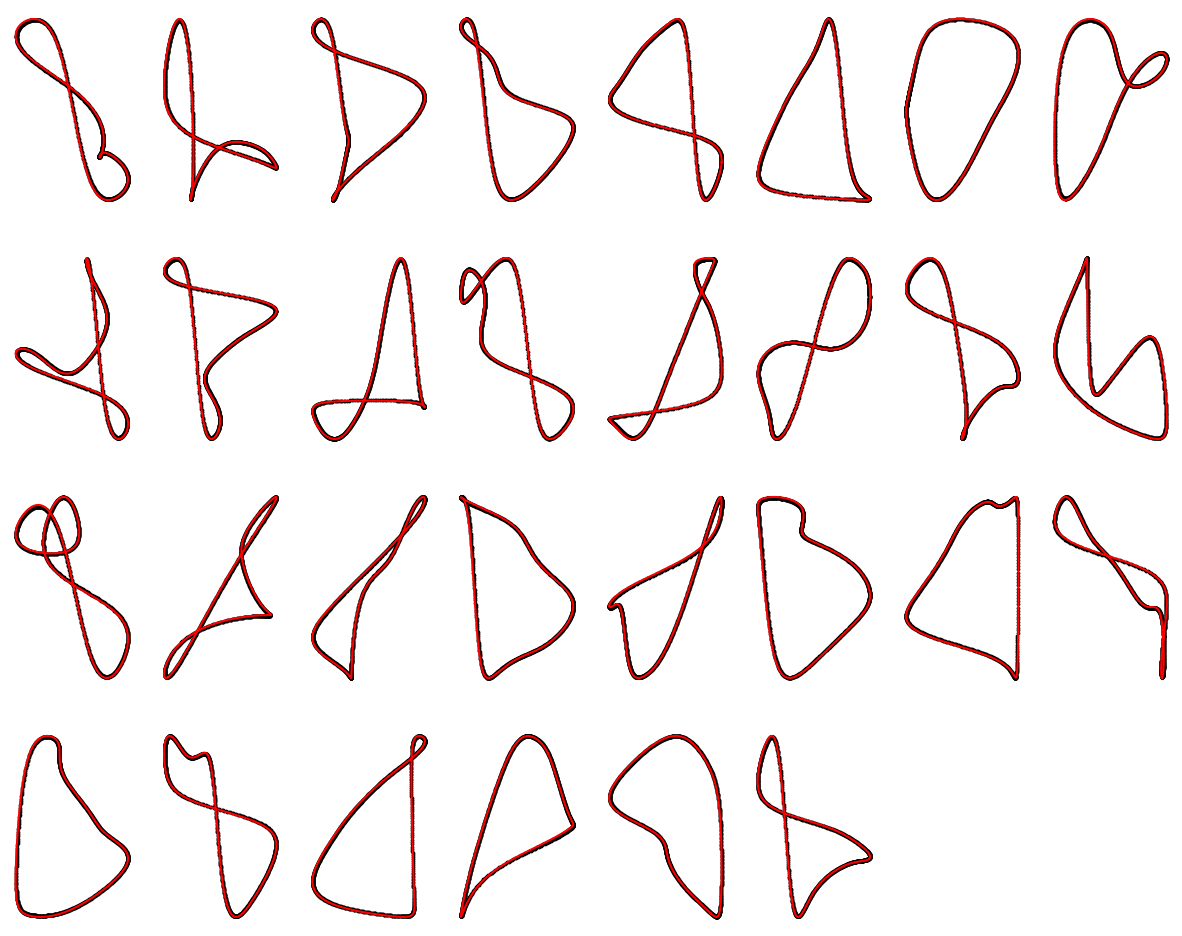

In [3]:

fig = plt.figure(figsize=(15,15))
for i in range(30):  
    
    
    ax = fig.add_subplot(5, 8, i+1)
    ax.scatter(test_pred[i,:].detach(), test_pred[i+1,:].detach(), s = 12, c = 'black', marker='.')  
    ax.plot(y_test[i,:].detach(), y_test[i+1,:].detach(), c='r')
    
    plt.axis('off')

Here, I have plotted the 'i-th' row in x-axis and 'i+1-th' row in y-axis for ground truth (in RED) and model prediction(in BLACK) for TEST Dataset:

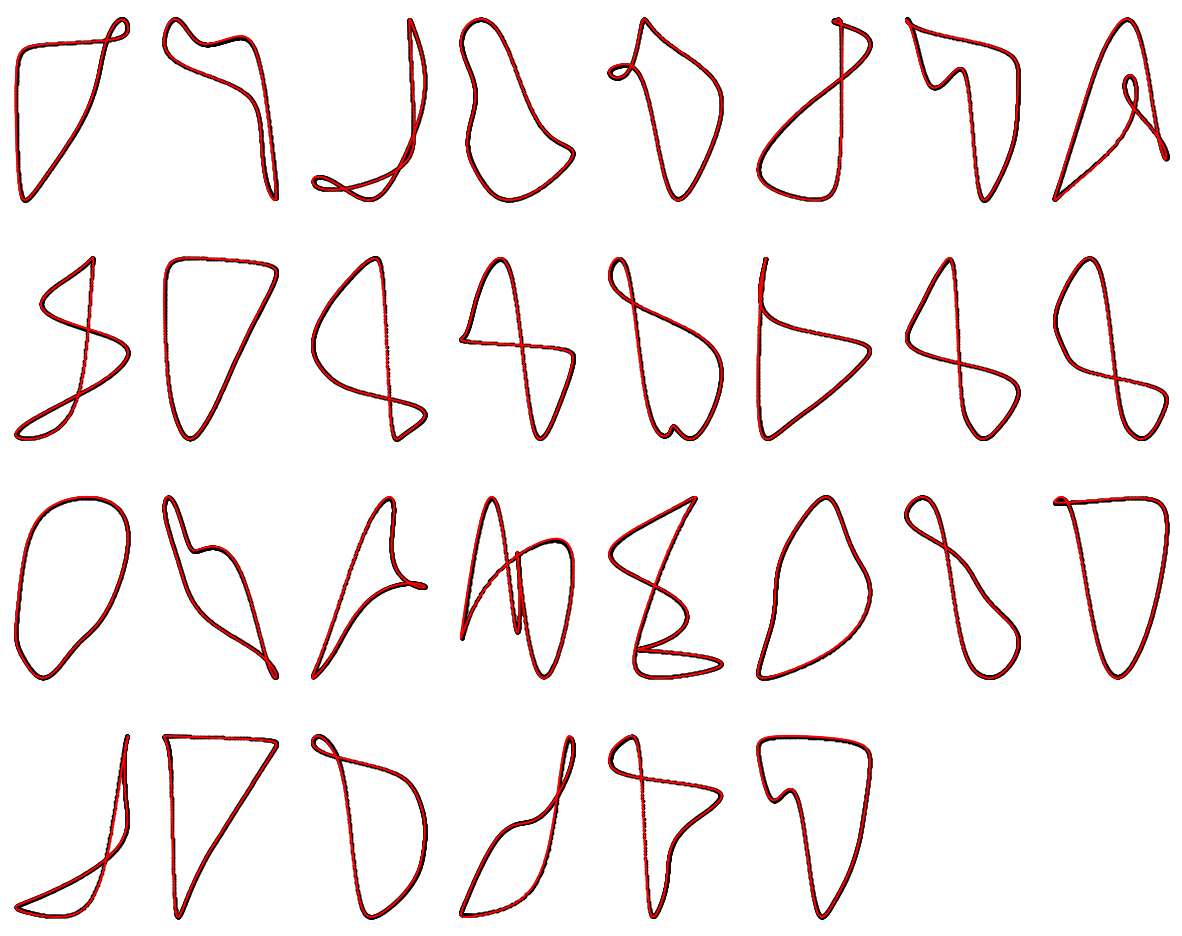

In [4]:

fig = plt.figure(figsize=(15,15))
for i in range(30):  
    
    
    ax = fig.add_subplot(5, 8, i+1)
    ax.scatter(pred[i,:].detach(), pred[i+1,:].detach(), s = 12, c = 'black', marker='.')  
    ax.plot(y_train[i,:].detach(), y_train[i+1,:].detach(), c='r')
    
    plt.axis('off')

*Plotting the training L2 loss with number of epochs*

Text(0, 0.5, 'l2 loss')

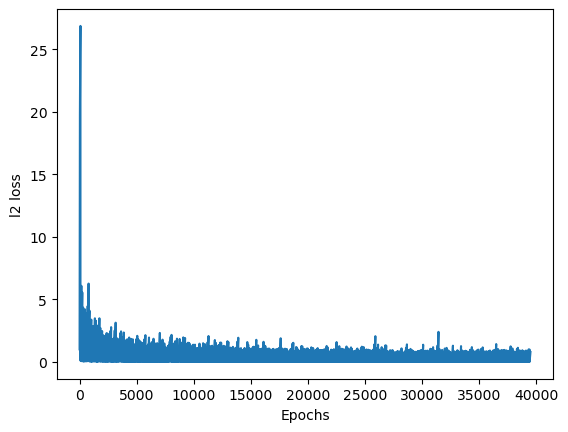

In [6]:
plt.plot(np.arange(1,len(train_l2List)+1,1), train_l2List)
plt.xlabel("Epochs")
plt.ylabel("l2 loss")

*Plotting Traiing MSE Loss with number of epochs*

Text(0, 0.5, 'MSE loss')

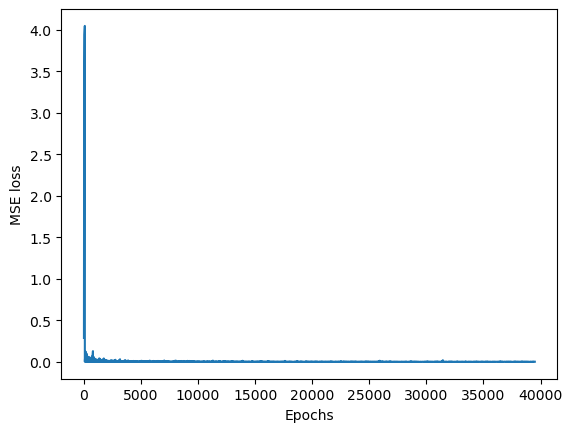

In [7]:
plt.plot(np.arange(1,len(train_mseList)+1,1), train_mseList)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")

*For Training Data*

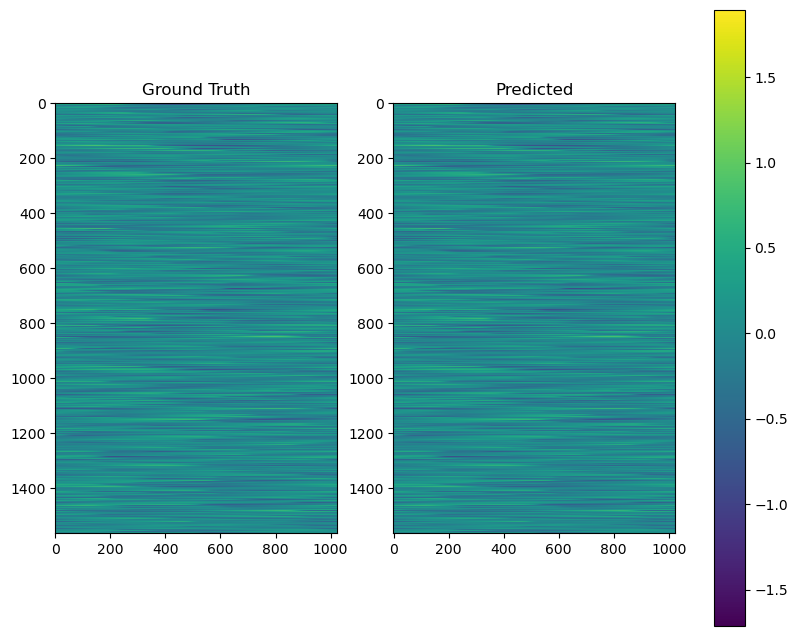

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))


ax2.imshow(pred.detach())
ax2.set_title('Predicted')

im = ax1.imshow(y_train)
ax1.set_title('Ground Truth')
fig.colorbar(im, ax=[ax1, ax2], orientation='vertical')

plt.show()

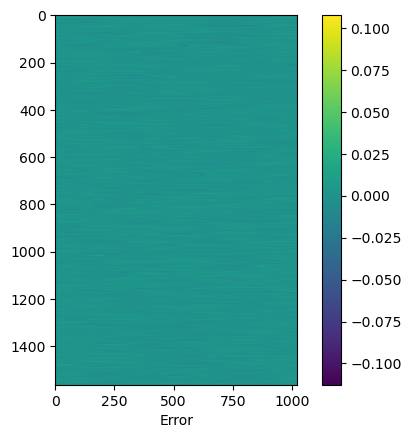

In [53]:
Errort = pred.detach() - y_train
plt.imshow(Errort)
plt.xlabel("Error")
plt.colorbar()

*For Testing Data*

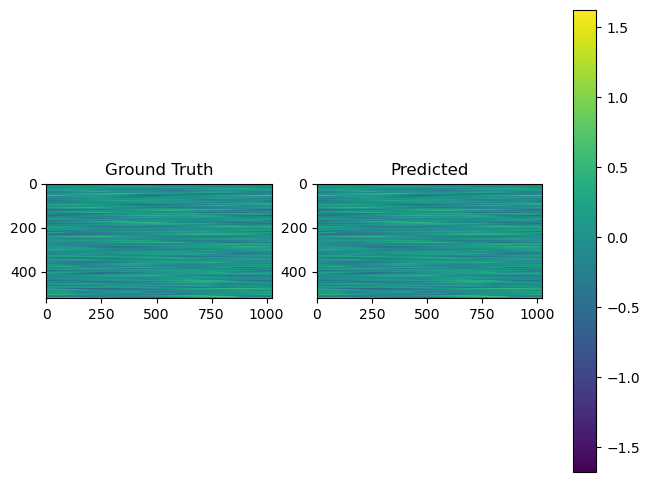

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))


ax2.imshow(test_pred.detach())
ax2.set_title('Predicted')

im = ax1.imshow(y_test)
ax1.set_title('Ground Truth')
fig.colorbar(im, ax=[ax1, ax2], orientation='vertical')
plt.show()

In [34]:
Error = test_pred.detach() - y_test

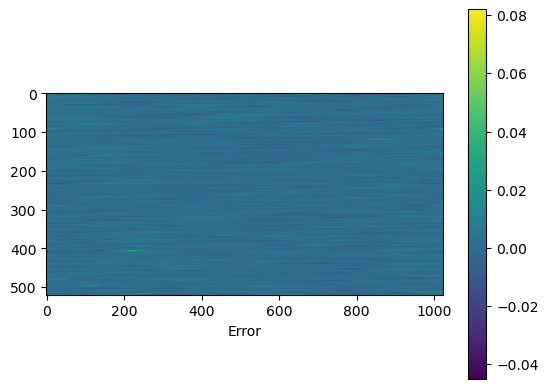

In [52]:
plt.imshow(Error)
plt.xlabel("Error")
plt.colorbar()

Submitted by: \
Soban Nasir Lone \
2022AMY7554